<a href="https://colab.research.google.com/github/mitra369/210112-CN_CIFAR10/blob/main/210112_CN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
!git clone https://github.com/mitra369/210112-CN_CIFAR10.git


fatal: destination path '210112-CN_CIFAR10' already exists and is not an empty directory.


In [147]:
import os
os.listdir("210112-CN_CIFAR10/dataset/phone image")


['truck1.png',
 'cat1.png',
 'bird1.png',
 'horse2.png',
 'cat3.png',
 'desktop.ini',
 'frog1.png',
 'cat2.png',
 'frog2.png',
 'car2.png',
 'horse1.png',
 'truck2.png',
 'deer1.png',
 'car1.png',
 'cat4.png',
 'dog2.png',
 'bird2.png',
 'cat5.png',
 'deer2.png',
 'car3.png',
 'bird3.png',
 'dog3.png',
 'dog1.png']

In [148]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [150]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [151]:
trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform)

testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform)


In [152]:
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]


In [153]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [154]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)   # ✅ 10 classes

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


In [155]:
model = CNN().to(device)


In [156]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [157]:
epochs = 10

train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(trainloader))
    train_acc.append(correct / total)

    # Validation
    model.eval()
    correct, total, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(running_loss / len(testloader))
    val_acc.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Acc: {train_acc[-1]*100:.2f}% | "
          f"Val Acc: {val_acc[-1]*100:.2f}%")


Epoch 1/10 | Train Acc: 51.68% | Val Acc: 60.45%
Epoch 2/10 | Train Acc: 65.34% | Val Acc: 67.48%
Epoch 3/10 | Train Acc: 71.19% | Val Acc: 69.85%
Epoch 4/10 | Train Acc: 75.09% | Val Acc: 72.28%
Epoch 5/10 | Train Acc: 78.34% | Val Acc: 72.59%
Epoch 6/10 | Train Acc: 81.45% | Val Acc: 73.03%
Epoch 7/10 | Train Acc: 84.24% | Val Acc: 72.63%
Epoch 8/10 | Train Acc: 86.67% | Val Acc: 73.00%
Epoch 9/10 | Train Acc: 89.18% | Val Acc: 71.93%
Epoch 10/10 | Train Acc: 91.16% | Val Acc: 71.79%


In [158]:
torch.save(model.state_dict(), "210112-CN_CIFAR10/model/210112.pth")


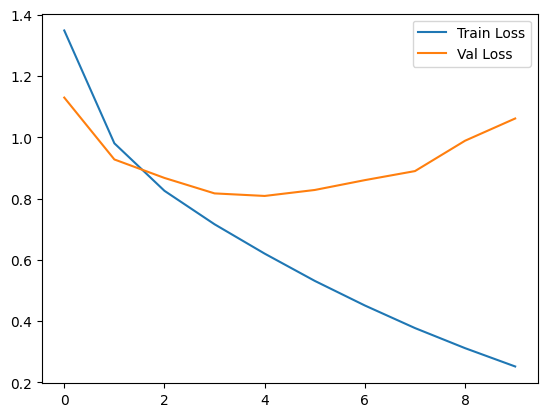

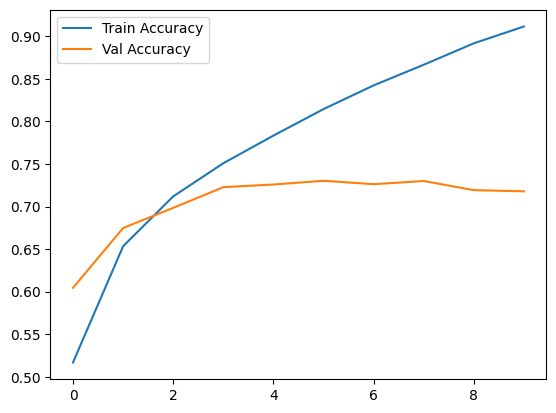

In [159]:
plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.show()


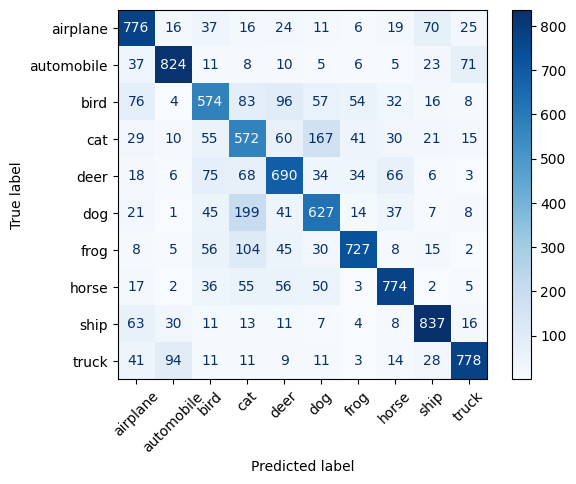

In [167]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(
    y_true,
    y_pred,
    labels=list(range(10))   # ✅ force all 10 classes
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=classes
)

disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


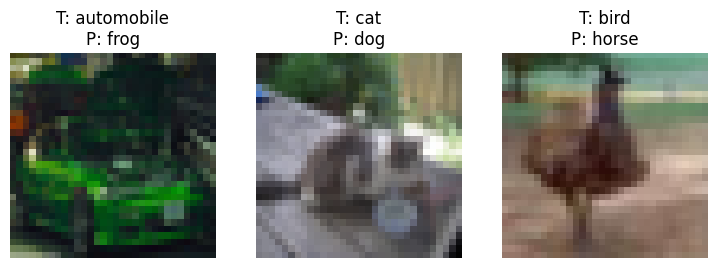

In [168]:
wrong = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
samples = random.sample(wrong, 3)

plt.figure(figsize=(9,3))
for i, idx in enumerate(samples):
    img = testset[idx][0].permute(1,2,0).numpy()
    img = (img + 1) / 2

    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(f"T: {classes[y_true[idx]]}\nP: {classes[y_pred[idx]]}")
    plt.axis("off")

plt.show()


In [163]:
phone_dir = "210112-CN_CIFAR10/dataset/phone image"

phone_imgs = [
    f for f in os.listdir(phone_dir)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
]


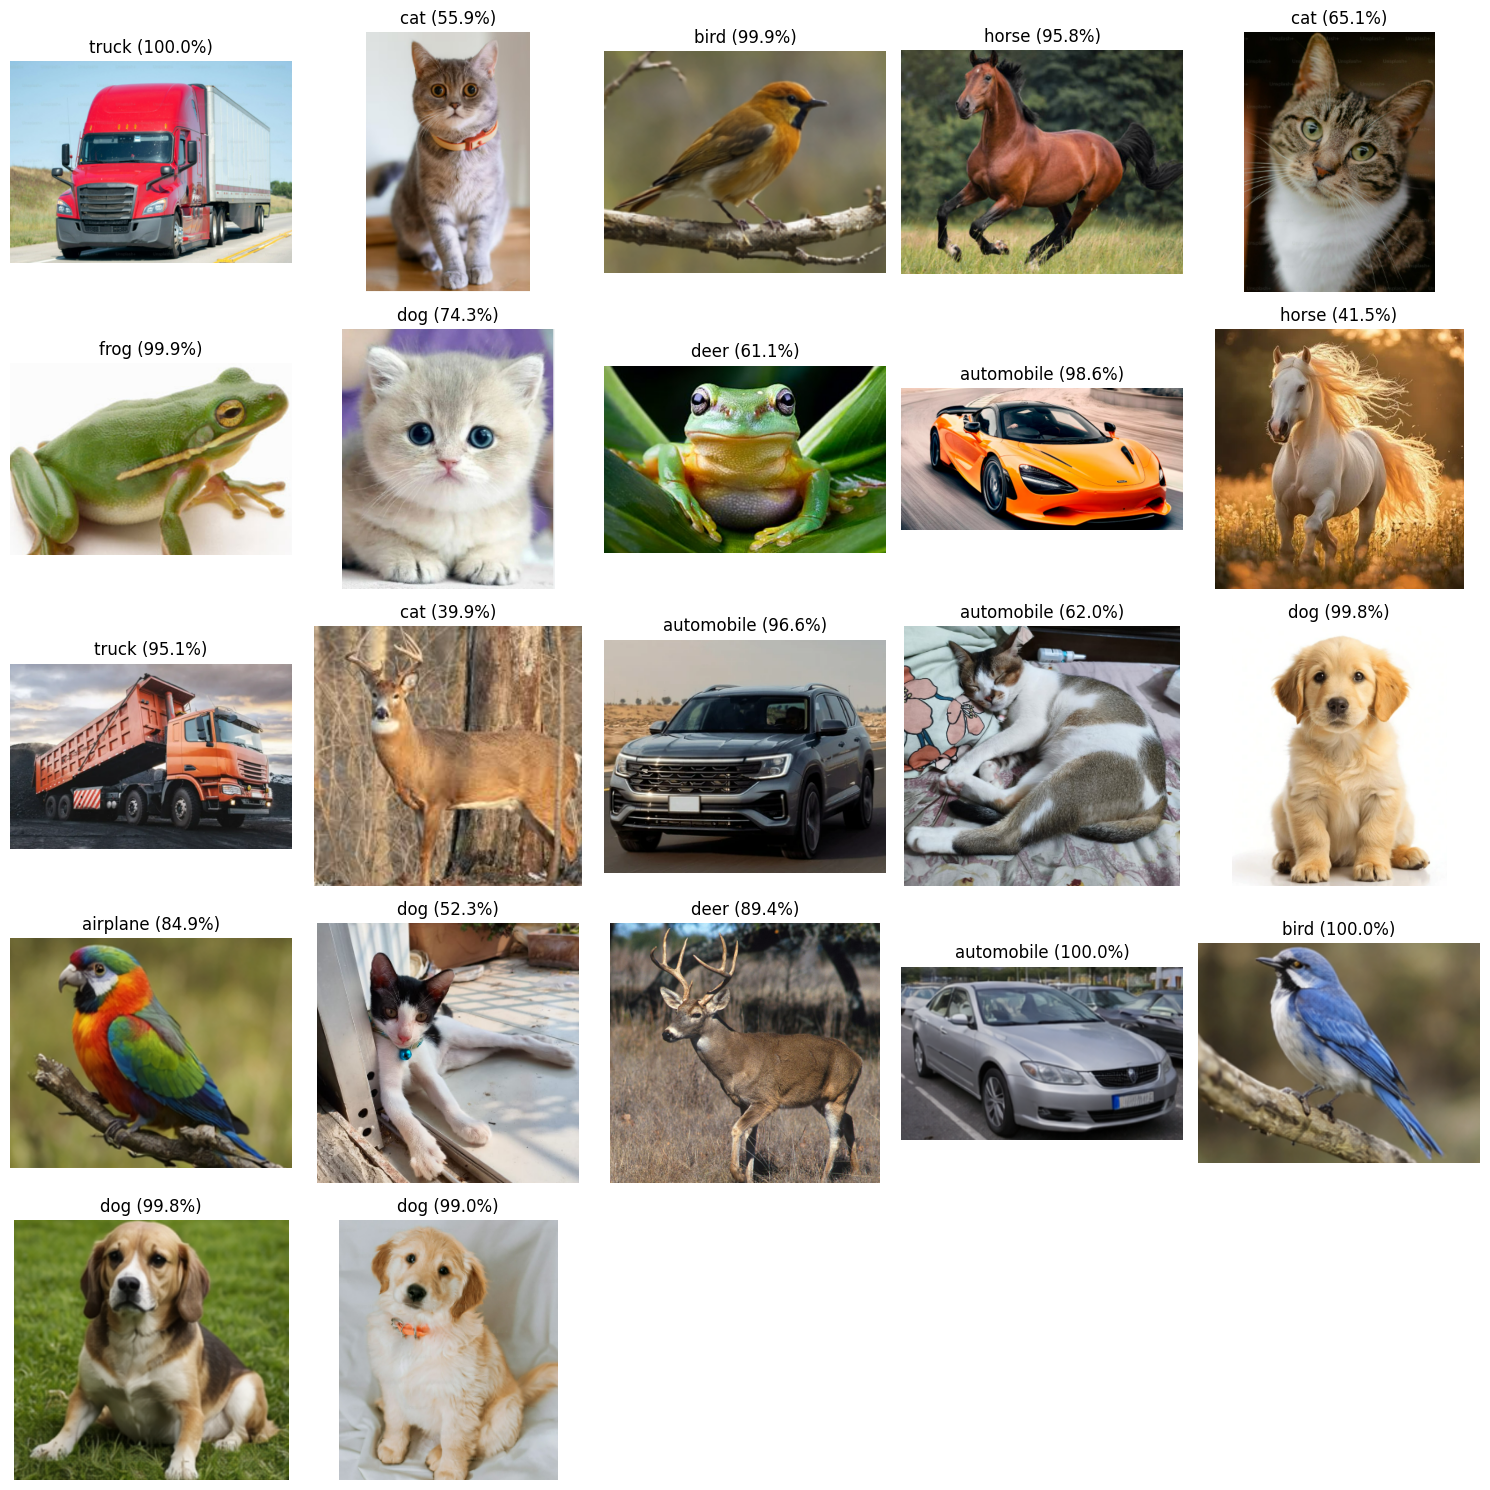

In [164]:
cols = 5
rows = math.ceil(len(phone_imgs) / cols)
plt.figure(figsize=(15, 3 * rows))

model.eval()
for i, img_name in enumerate(phone_imgs):
    img_path = os.path.join(phone_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(f"{classes[pred.item()]} ({conf.item()*100:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [166]:
from google.colab import files

# Replace with your actual path to the model
files.download("210112-CN_CIFAR10/model/210112.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>